In [200]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Clase DataSet para instanciar cada experimento  

In [201]:
class DataSet:
    def __init__(self, test, run):
        self.test = test
        self.run = run
        self.path = '../MOSFET_Thermal_Overstress_Aging_v0/Test_{}_run_{}.mat'
        self.data_set = None
        self.data_set_on = None
        self.initialize()
        
    
    def __str__(self):
        msg = f"Información experimento {self.test} run {self.run}"
        return msg

    def initialize(self):
        self.document_reader()
        self.df_filter()
    
    def document_reader(self):
        # Solo se crean cuando se instancian estas listas
        time_pwm = list()
        pwm_list = list()
        time_open = list()
        time_df = list()
        drain_currrent_df = list()
        ds_voltage_df = list()
        temperature_df = list()

        # Cargar el archivo .mat

        # Liste de tuplas que incluye el tiempo donde gateState == 1. Estas tuplas van de (tiempo apertura, tiepo cierre) y el tiempo de cierre es el siguiente momento donde gateState == 0.
        # Si el experimento termina en gateState == 1, el tiempo de cierre es infinito.

        for i in range(self.run):
            path = self.path.format(self.test, i+1)
            try:
                measurement = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)['measurement']
            except FileNotFoundError:
                print(f"Archivo {path} no encontrado.")
            except Exception as e:
                print(f"Error al cargar el archivo {path}: {e}")
                continue
            pwm = measurement.pwmTempControllerState
            init = True
            for i in range(len(pwm)):
                if init:
                    t_init_pwm = datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
                    init = False
                time_pwm.append(datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()-t_init_pwm)
                pwm_list.append(pwm[i].gateState)
                
                if pwm[i].gateState == 1:
                    t_open = datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
                    try:
                        t_close = datetime.strptime(pwm[i+1].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
                    except IndexError:
                        t_close = float('inf')

                    time_open.append((t_open,t_close))
                
            # Acceder al campo 'steady'
            steady = measurement.steadyState 
            
            for measure in steady:
                
                fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()   
                time_df.append(fecha_dt)         

                # Leer corriente del drain 
                drain_current_n = measure.timeDomain.drainCurrent
                drain_currrent_df.append(drain_current_n)

                # Leer voltaje drain-source
                ds_voltage_n = measure.timeDomain.drainSourceVoltage
                ds_voltage_df.append(ds_voltage_n)

                # Leer temperatura
                temperature_n = measure.timeDomain.flangeTemperature
                temperature_df.append(temperature_n)
            # Aqui hago dataframe de pandas para filtrar los datos.
            # Filtro solo la corriente y voltajes que se encuentran en los intervalos de tiempo donde gateState == 1.

            df = pd.DataFrame({'time': time_df, 'drain_current': drain_currrent_df, 'ds_voltage': ds_voltage_df , 'temperature': temperature_df})
            df["R_ds"] = df["ds_voltage"]/df["drain_current"] # Resistencia entre drain y source
            #df['time'] = pd.to_datetime(df['time'], unit='s')
            #dfs = [df[(df["time"] >= start) & (df["time"] <= end)] for start, end in time_open]
            #filtered_df = pd.concat(dfs).sort_index()
            self.data_set = df

    def min_max_normalization(self):
        self.data_set_on["R_ds"] = gaussian_filter1d(self.data_set_on["R_ds"], sigma=5) # Suavizado de la resistencia entre drain y source
        Min = self.data_set_on["R_ds"].min()
        Max = self.data_set_on["R_ds"].max()
        init_value = self.data_set_on["R_ds"].iloc[0]
        self.data_set_on["R_ds Min Max Norm"] = self.data_set_on["R_ds"].apply(lambda x: (x - init_value)/(Max - Min))
    
    def pwm_on_filter(self):
        i_rms = np.sqrt(np.mean(self.data_set["drain_current"]**2)) # RMS de la corriente del drain
        print(i_rms)
        self.data_set_on = self.data_set[self.data_set["drain_current"] > i_rms]

    def df_filter(self):
        time_init = self.data_set["time"].iloc[0]
        self.data_set["time"] = self.data_set["time"].apply(lambda x: (x - time_init)/60)
        self.pwm_on_filter()
        self.filter_current()
        self.min_max_normalization()
        
    def filter_current(self):
        self.data_set_on = self.data_set_on[self.data_set_on["drain_current"] < self.data_set_on["drain_current"].quantile(0.99)]
        
        

# Instancias de Data sets

In [202]:
data_36 = DataSet(36,1)

df_36 = data_36.data_set
df_on_36 = data_36.data_set_on

1.6945301741562757


In [203]:
data_8 = DataSet(8,7)
df_8 = data_8.data_set
df_on_8 = data_8.data_set_on

data_9 = DataSet(9, 7)
df_9 = data_9.data_set
df_on_9 = data_9.data_set_on

1.8110779027369879
1.8698877361933213


In [204]:
data_10 = DataSet(10,7)
df_10 = data_10.data_set
df_on_10 = data_10.data_set_on


Error al cargar el archivo ../MOSFET_Thermal_Overstress_Aging_v0/Test_10_run_3.mat: Expecting matrix here
1.7098257476866288


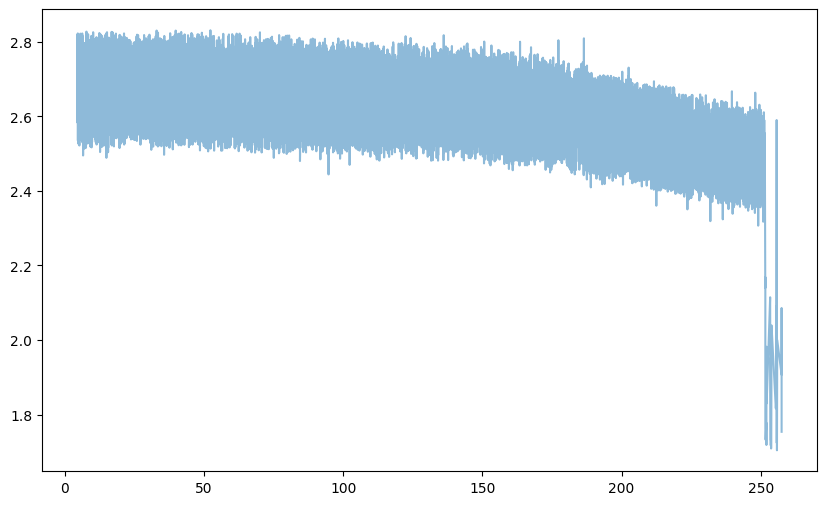

In [205]:
#plot current
plt.figure(figsize=(10, 6))

plt.plot(df_on_36["time"], df_on_36["drain_current"], label='Test 36', alpha=0.5) 

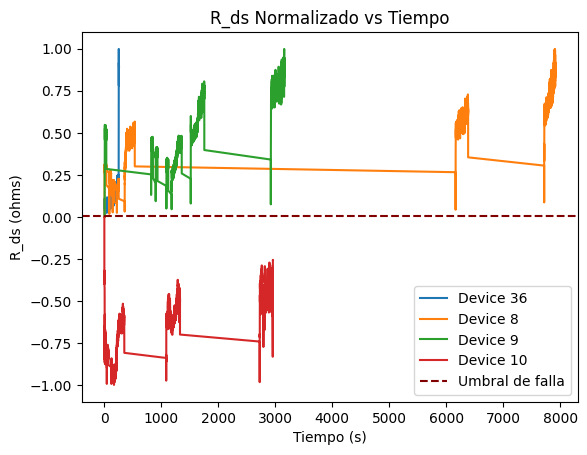

In [212]:
plt.plot(df_on_36["time"], gaussian_filter1d(df_on_36["R_ds Min Max Norm"], sigma = 1), label="Device 36")
plt.plot(df_on_8["time"], gaussian_filter1d(df_on_8["R_ds Min Max Norm"], sigma = 1), label="Device 8")
plt.plot(df_on_9["time"], gaussian_filter1d(df_on_9["R_ds Min Max Norm"], sigma = 1), label="Device 9")
plt.plot(df_on_10["time"], gaussian_filter1d(df_on_10["R_ds Min Max Norm"], sigma = 1), label="Device 10")
plt.axhline(y = 0.008, linestyle = "--", color = "maroon", label = "Umbral de falla")
plt.title("R_ds Normalizado vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("R_ds (ohms)")
plt.legend()
plt.show()

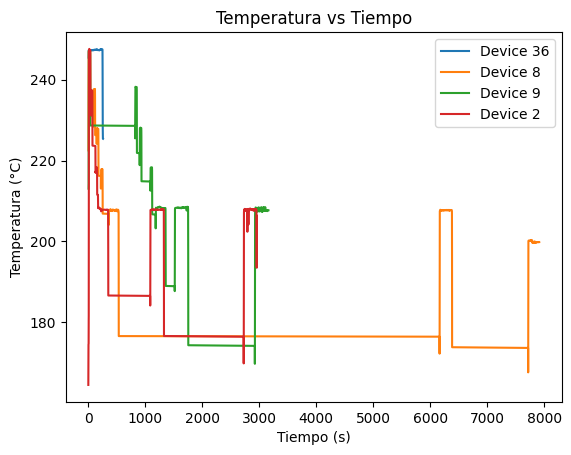

In [207]:
plt.plot(df_on_36["time"], gaussian_filter1d(df_on_36["temperature"], sigma = 100), label="Device 36")
plt.plot(df_on_8["time"], gaussian_filter1d(df_on_8["temperature"], sigma = 100), label="Device 8")
plt.plot(df_on_9["time"], gaussian_filter1d(df_on_9["temperature"], sigma = 100), label="Device 9")
plt.plot(df_on_10["time"], gaussian_filter1d(df_on_10["temperature"], sigma = 100), label="Device 2")
plt.title("Temperatura vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()